In [1]:
import sys

sys.path.insert(0, "../../..")
from paths import DATA_DIR, FIG_DIR

import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt

from graphvelo.graph_velocity import GraphVelo
from graphvelo.utils import mack_score, adj_to_knn
from graphvelo.plot import gene_score_histogram, plot_velocity_phase

In [2]:
scv.settings.figdir = str(FIG_DIR)
scv.settings.set_figure_params(
    "scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map="viridis"
)
scv.settings.plot_prefix = ""

In [3]:
save_figure = True

In [4]:
adata = sc.read(DATA_DIR / "setty_bone_marrow_cr.h5ad")
adata

AnnData object with n_obs × n_vars = 5780 × 27876
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential'
    var: 'palantir'
    uns: 'clusters_colors', 'palantir_branch_probs_cell_types'
    obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs'
    layers: 'spliced', 'unspliced'

## Velocity estimation using scvelo

In [5]:
scv.pp.filter_and_normalize(
    adata, min_shared_counts=20, n_top_genes=2000, subset_highly_variable=True
)

sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=0)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 20068 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/opt/anaconda3/envs/gv-reprod/lib/python3.8/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [6]:
scv.tl.recover_dynamics(adata, n_jobs=-1)
scv.tl.velocity(adata, mode="dynamical")
scv.tl.latent_time(adata)

recovering dynamics (using 10/10 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:44) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


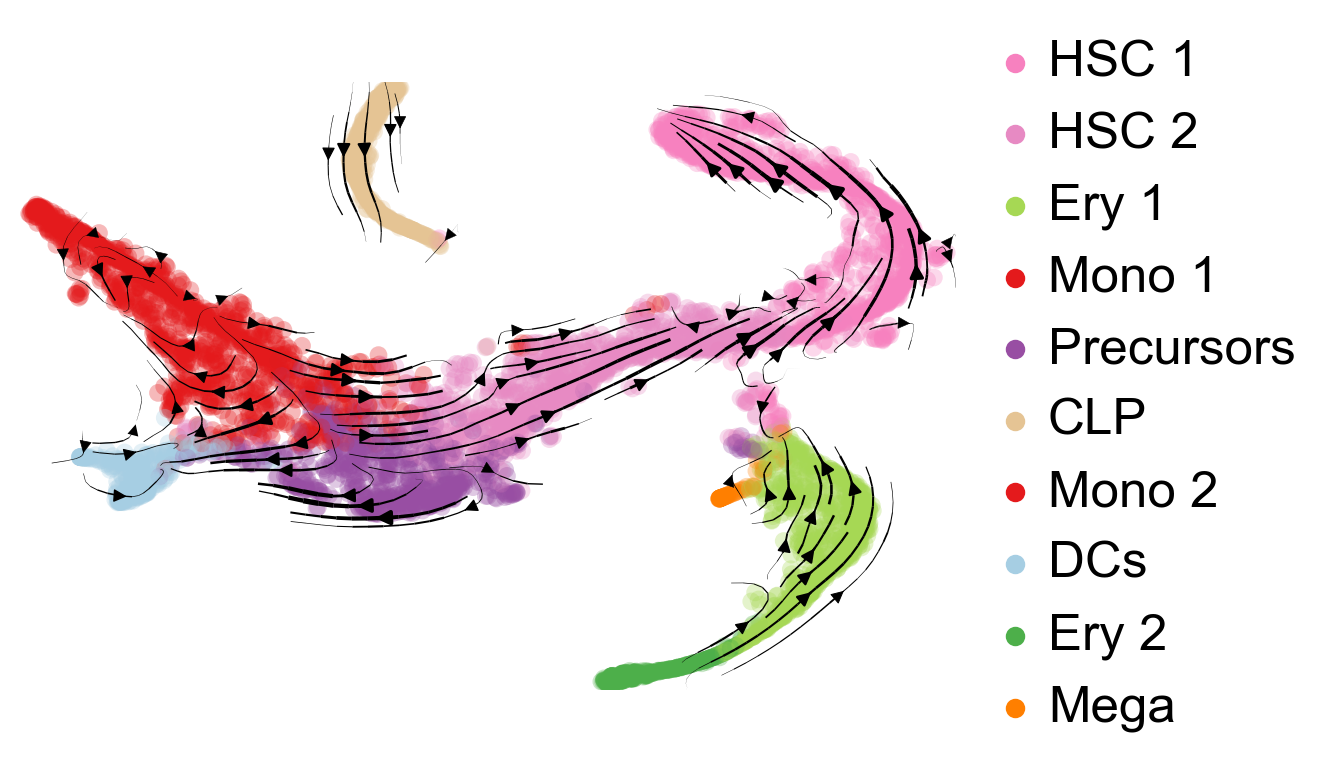

In [7]:
fig_kwargs = {"color": ["clusters"], "legend_loc": "right", "dpi": 100, "title": ""}
# if save_figure: fig_kwargs['save'] = scv.settings.figdir + '/suppl_figures_hspc/velocities_umap_streamlines.png'
scv.pl.velocity_embedding_stream(adata, **fig_kwargs)

check velocity genes with top likelihood in dynamical model.

In [8]:
genes = ["ANGPT1", "RBPMS"]

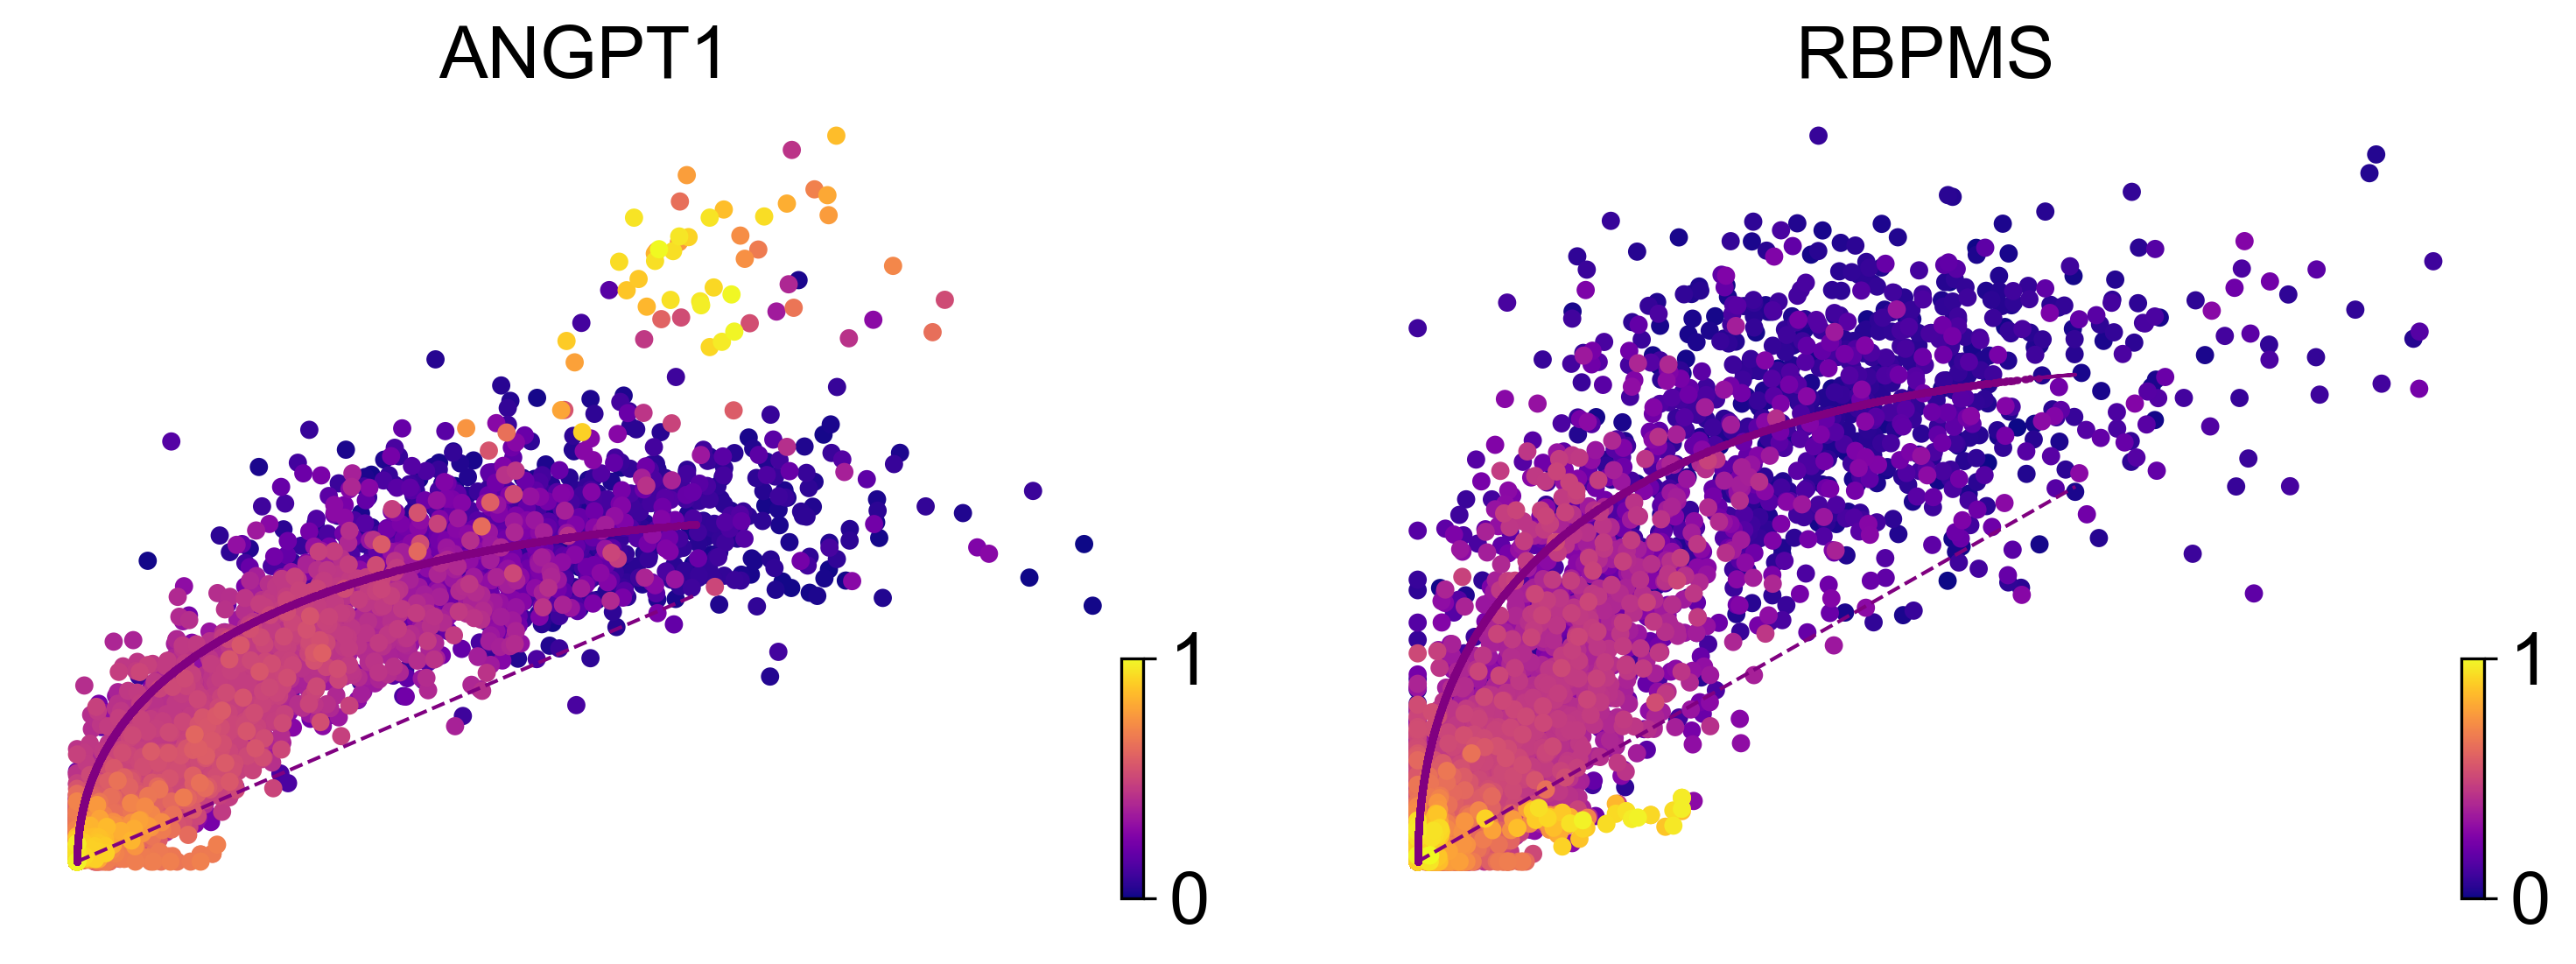

In [9]:
fig_kwargs = {
    "basis": genes,
    "color": "palantir_pseudotime",
    "color_map": "plasma",
    "frameon": False,
    "s": 100,
    "dpi": 150,
}
scv.pl.scatter(adata, **fig_kwargs)

high degration: ANGPT1, NPR3, MSI2
transcription burst: CALR, KLF1, AHSP, NPR3

## Run GraphVelo

In [10]:
indices, _ = adj_to_knn(adata.obsp["connectivities"])
adata.uns["neighbors"]["indices"] = indices

In [11]:
mack_score(adata, ekey="Ms", vkey="velocity", tkey="palantir_pseudotime")

calculating manifold-consistent scores in 10 cpu(s): 100%|██████████| 588/588 [00:26<00:00, 21.96it/s]


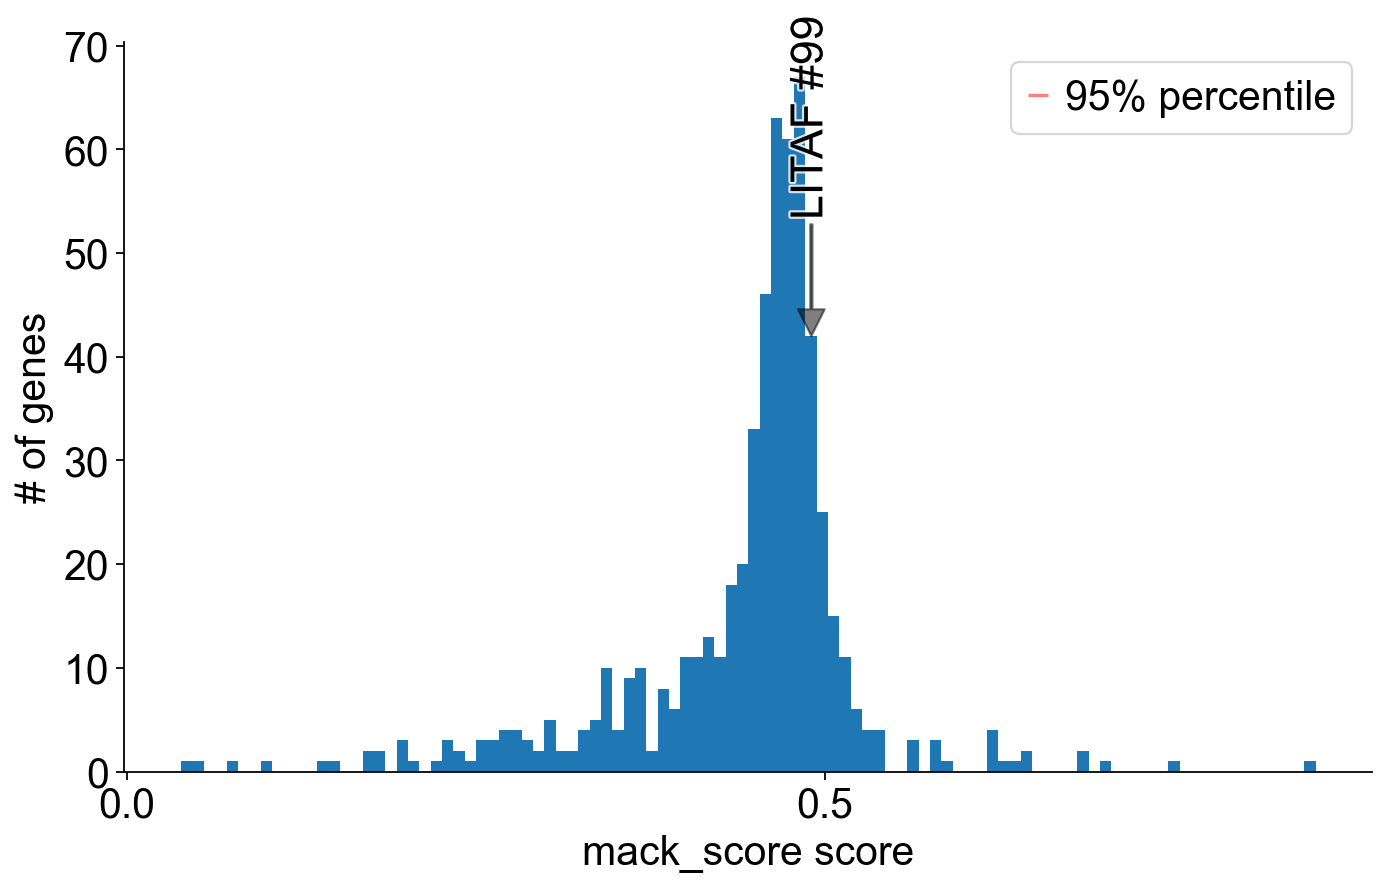

In [12]:
macKG = adata.var["mack_score"].sort_values(ascending=False)[:100].index.to_list()
fig = gene_score_histogram(adata, genes=[macKG[-1]], score_key="mack_score")
plt.show()

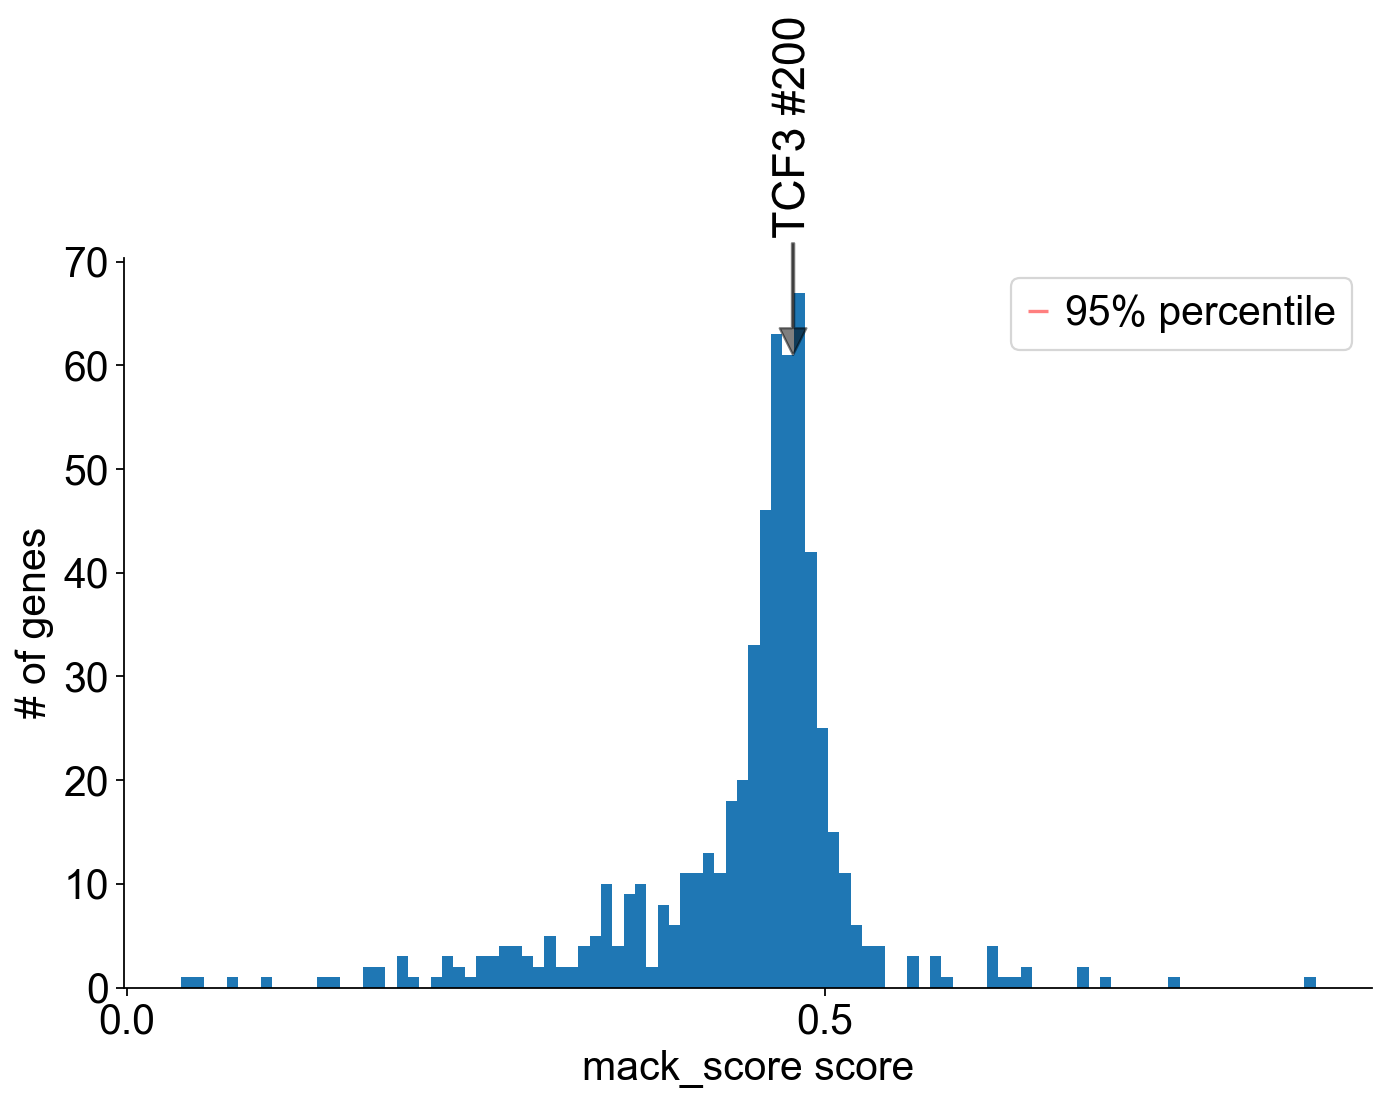

In [14]:
macKG_200 = adata.var["mack_score"].sort_values(ascending=False)[:200].index.to_list()
fig = gene_score_histogram(adata, genes=[macKG_200[-1]], score_key="mack_score")
plt.show()

Learning Phi in tangent space projection.: 100%|██████████| 5780/5780 [00:02<00:00, 2822.59it/s]


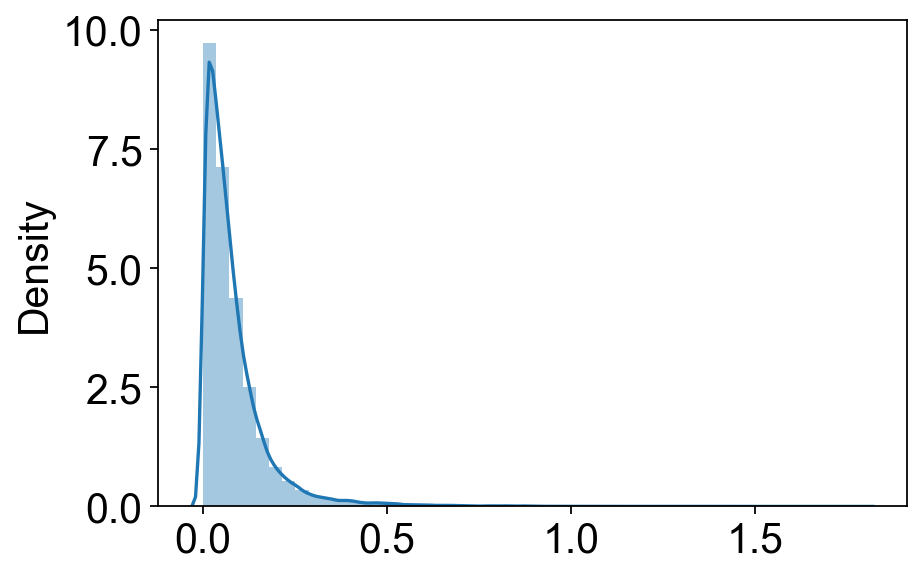

In [13]:
gv = GraphVelo(adata, gene_subset=macKG)
gv.train()
gv.write_to_adata(adata)
gv.plot_phi_dist()

In [14]:
adata.layers["velocity_gvs"] = gv.project_velocity(adata.layers["Ms"])
adata.layers["velocity_gvu"] = gv.project_velocity(adata.layers["Mu"])
adata.obsm["gv_pca"] = gv.project_velocity(adata.obsm["X_pca"])
adata.obsm["gv_tsne"] = gv.project_velocity(adata.obsm["X_tsne"])

projecting velocity vector to low dimensional embedding: 100%|██████████| 5780/5780 [00:01<00:00, 4746.61it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 5780/5780 [00:01<00:00, 4434.07it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 5780/5780 [00:00<00:00, 16252.39it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 5780/5780 [00:00<00:00, 17691.11it/s]


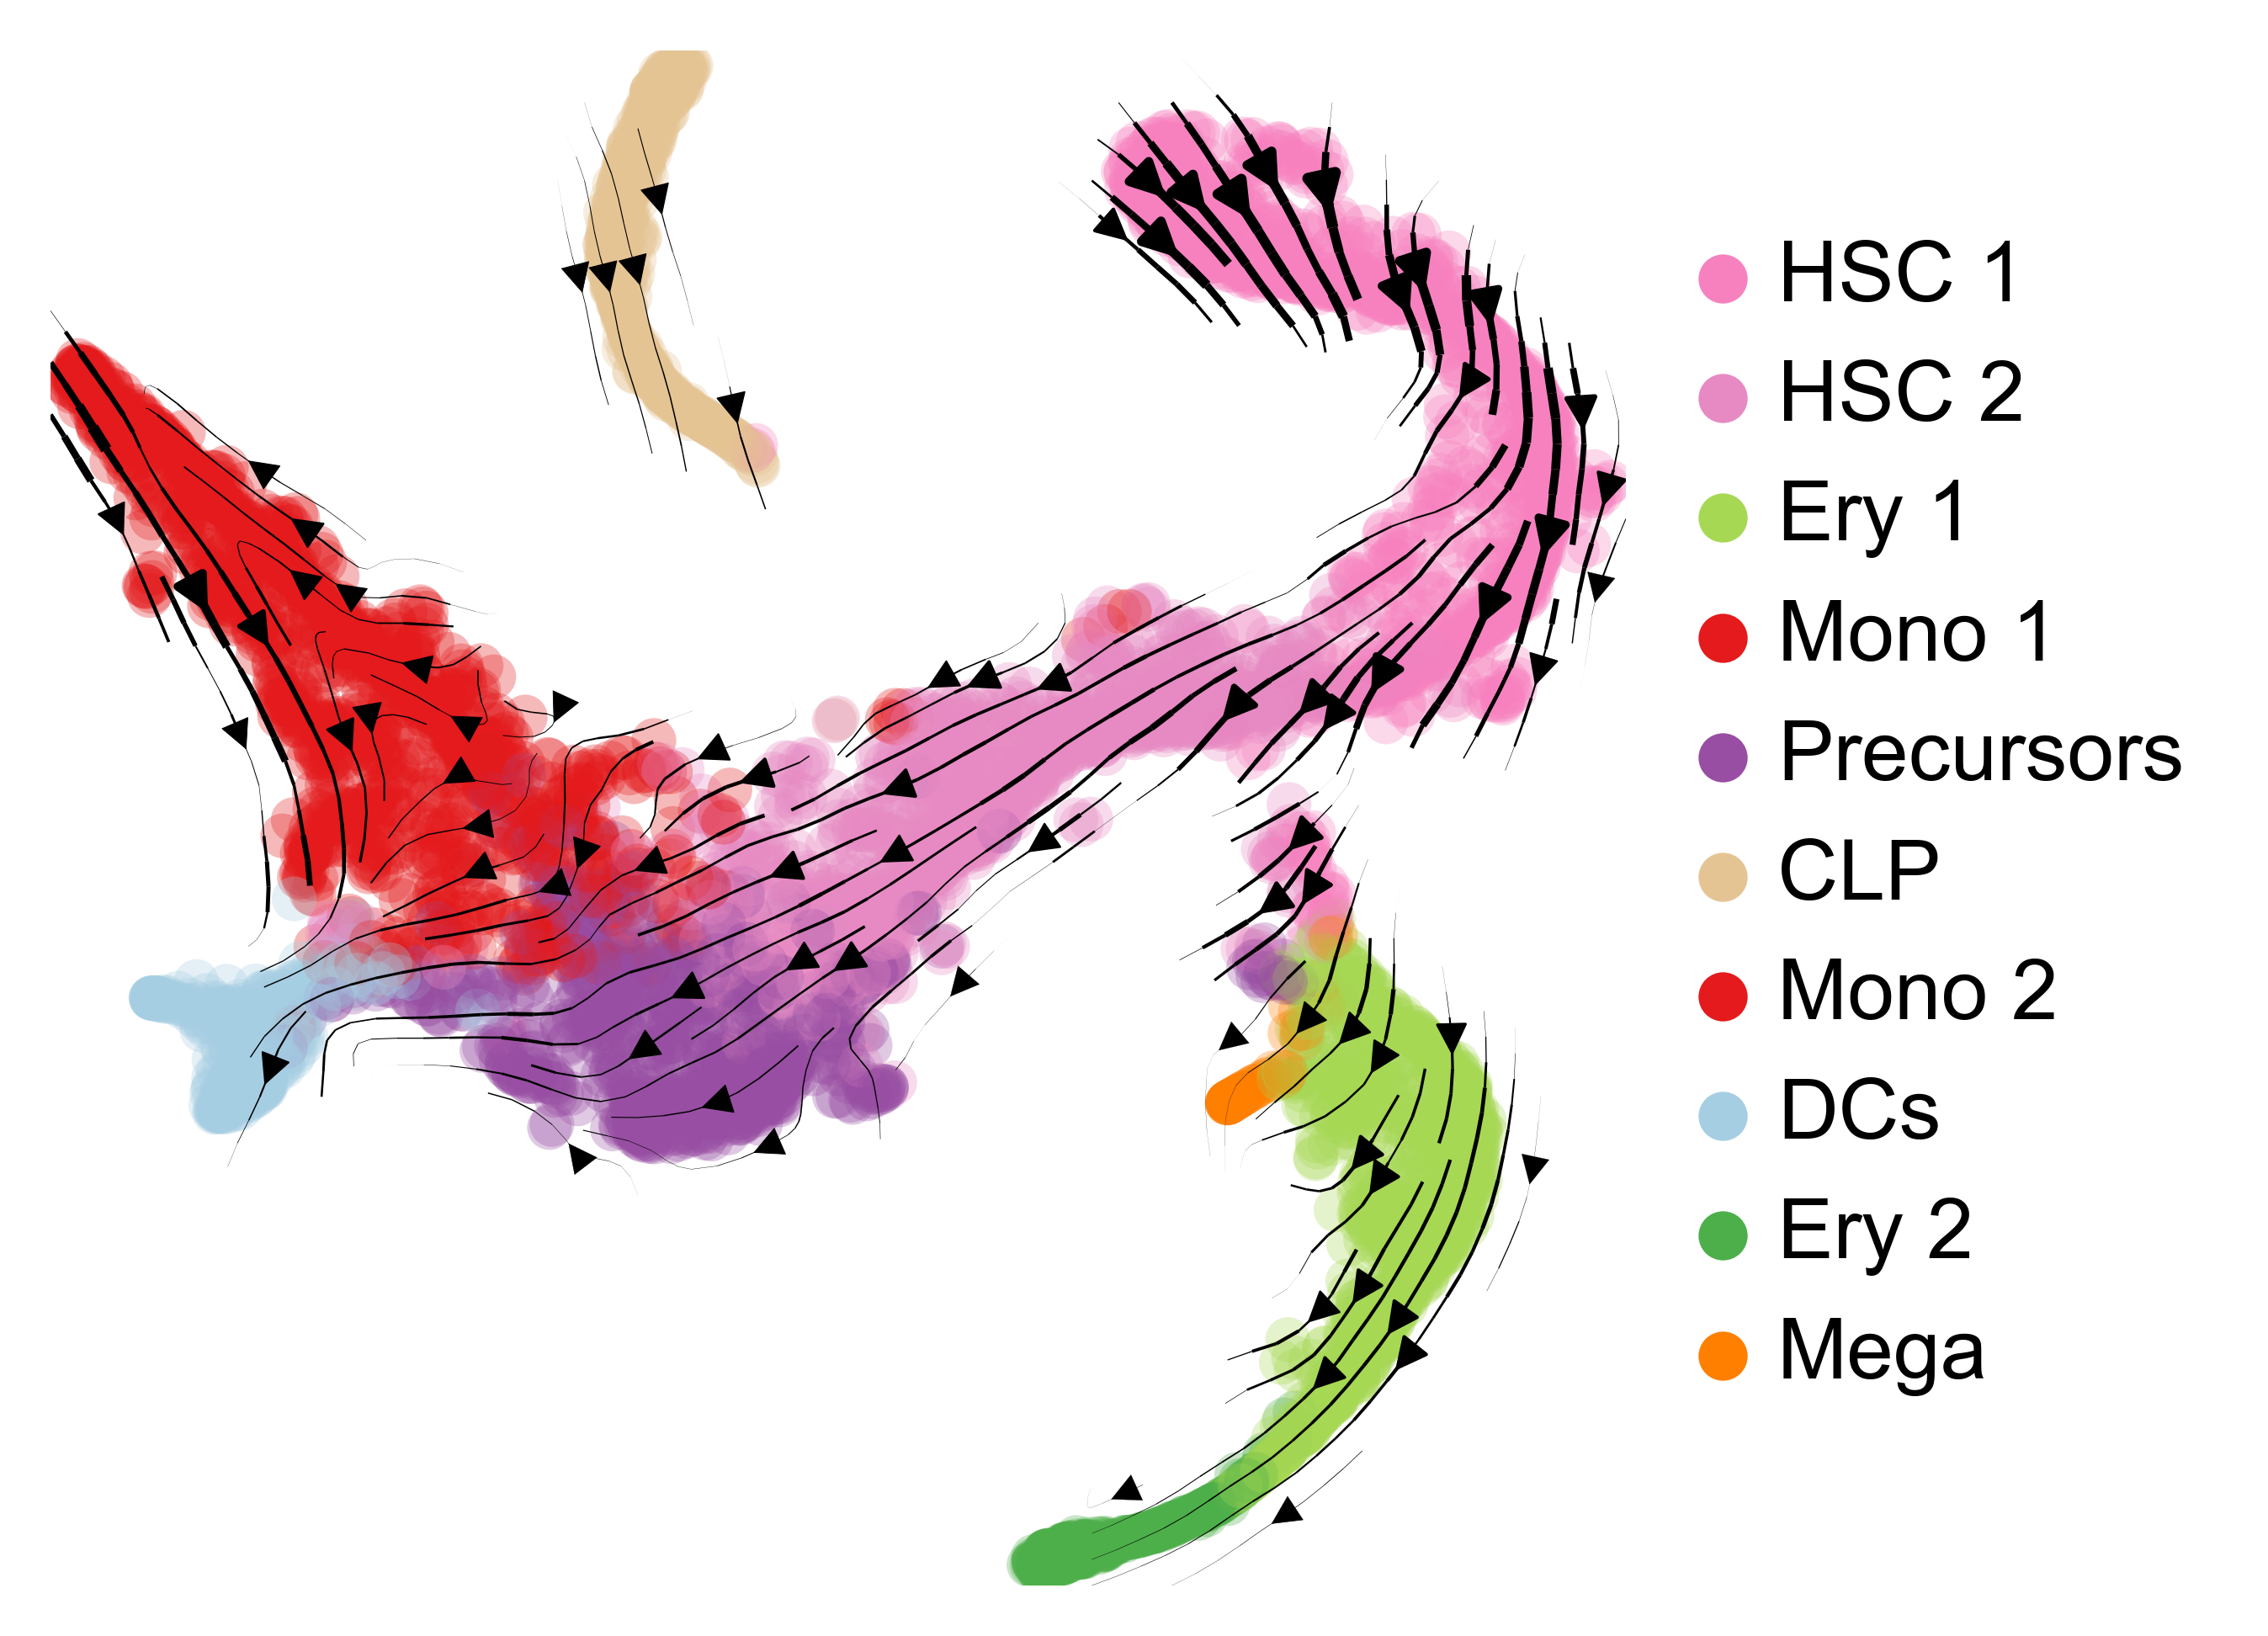

In [15]:
fig_kwargs = {
    "color": ["clusters"],
    "X": adata.obsm["X_tsne"],
    "V": adata.obsm["gv_tsne"],
    "legend_loc": "right",
    "dpi": 300,
    "title": "",
    "legend_fontsize": 12,
    "figsize": (4, 4),
}
# if save_figure: fig_kwargs['save'] = scv.settings.figdir + '/suppl_figures_hspc/gv_result.png'
scv.pl.velocity_embedding_stream(adata, **fig_kwargs)

Plotting velocity in phase diagram: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


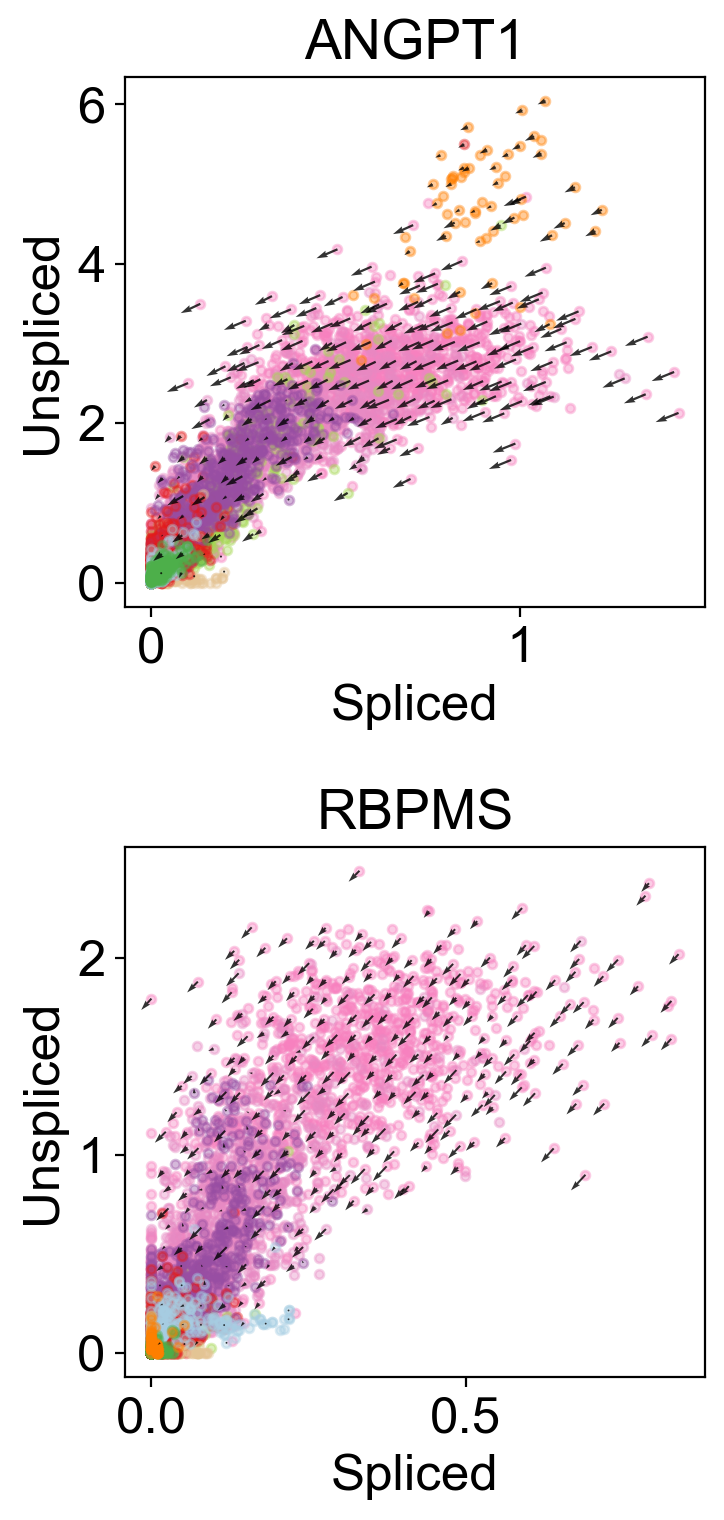

In [16]:
kwargs = {
    "genes": genes,
    "color": "clusters",
    "s_layer": "Ms",
    "u_layer": "Mu",
    "vs_layer": "velocity_gvs",
    "vu_layer": "velocity_gvu",
    "pointsize": 10,
    "ncols": 1,
    "scale": 3,
    "downsample": 0.1,
    "quiver_alpha": 0.8,
    "figsize": (4.2, 8),
    "show": False,
}
ax = plot_velocity_phase(adata, **kwargs)
# plt.savefig(str(FIG_DIR)+'/suppl_figures_mouse_ery/murk_gv100_phase.pdf', dpi=300, transparent=True)
plt.show()

Plotting velocity in phase diagram: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


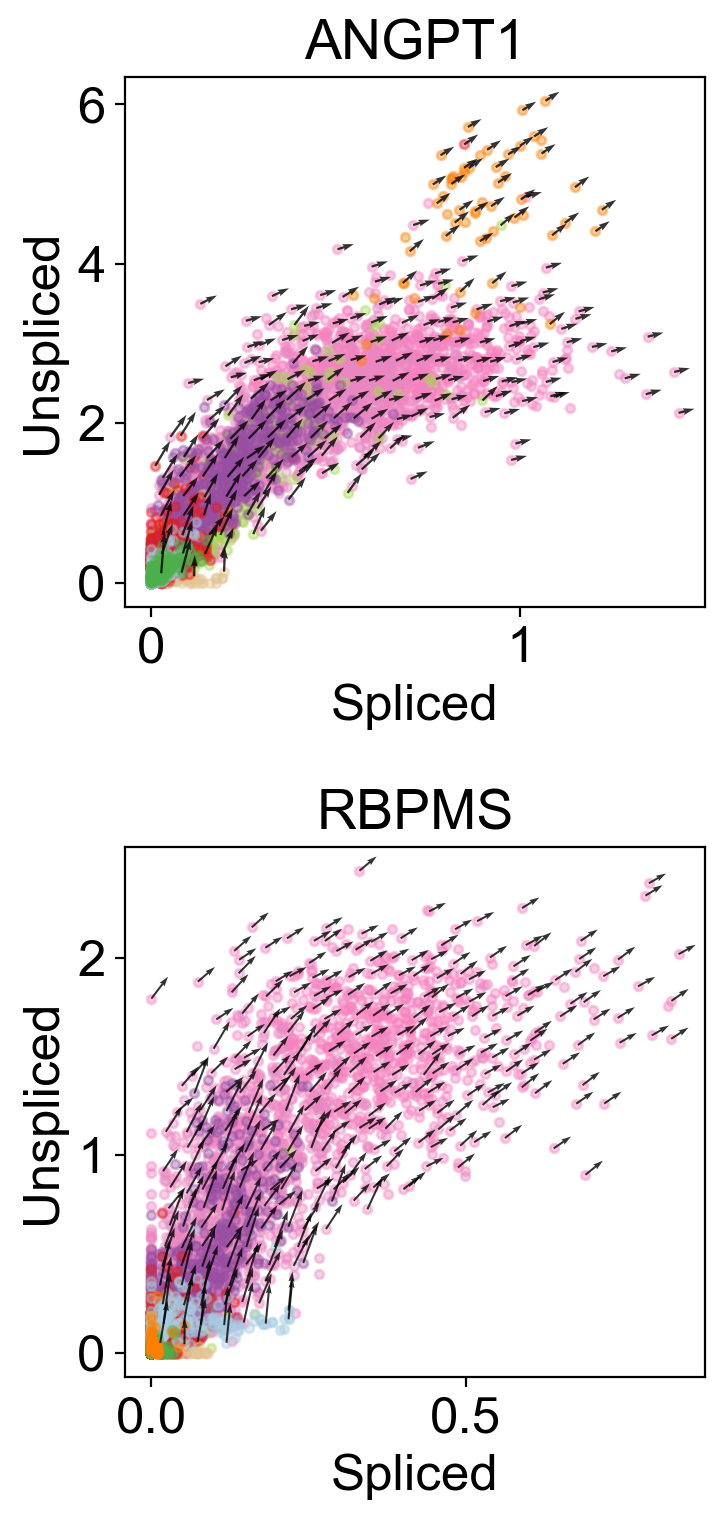

In [17]:
kwargs = {
    "genes": genes,
    "color": "clusters",
    "s_layer": "Ms",
    "u_layer": "Mu",
    "vs_layer": "velocity",
    "vu_layer": "velocity_u",
    "pointsize": 10,
    "ncols": 1,
    "scale": 1,
    "downsample": 0.1,
    "quiver_alpha": 0.8,
    "figsize": (4.2, 8),
    "show": False,
}
ax = plot_velocity_phase(adata, **kwargs)
# plt.savefig(str(FIG_DIR)+'/suppl_figures_hspc/genes_phase_velo.pdf', dpi=300, transparent=True)
plt.show()

In [ ]:
adata.write("hspc_gv.h5ad")